## Imports

Import our data and packages

In [469]:
# Import libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)


In [428]:
df = pd.read_csv('../data/teams_csv')
print (f'Our data has {df.shape[0]} rows and {df.shape[1]} columns.')
df.head()

Our data has 114254 rows and 43 columns.


,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,TS%,eFG%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,STL%,BLK%,TOV%,USG%,ORtg,DRtg,BPM
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,DeMar DeRozan,32:03,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Kyle Lowry,31:20,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Jonas Valančiūnas,30:30,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Norman Powell,24:35,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Serge Ibaka,24:14,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


## Data Cleaning

First, let's look at how many games were played in the regular season from 2017 - 2019.

In [429]:
num_games = 0
for team in list(df["Team"].unique()):
    num_games += df.loc[(df["Team"] == team) &
                        (df["Player"] == "Team Totals"), "Player"].count()

if num_games / (30 *2)  != 164:
    print ("Something went wrong.")
else:
    print ("All games collected!")

message = (
    f'From the {df["Season"][0]} NBA season through the {df["Season"][df.shape[0]-1]} season, there were a total of '
    f'{int(num_games/4)} games played during the regular seasons.' 
)

print (message)

All games collected!
From the 2018 NBA season through the 2019 season, there were a total of 2460 games played during the regular seasons.


### Data Types

In [430]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114254 entries, 0 to 114253
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Season             114254 non-null  int64  
 1   Time Period        114254 non-null  object 
 2   Date               114254 non-null  object 
 3   Team               114254 non-null  object 
 4   Team Abbreviation  114254 non-null  object 
 5   Location           114254 non-null  object 
 6   Overtime           5602 non-null    object 
 7   Result             114254 non-null  object 
 8   Player             114254 non-null  object 
 9   MP                 114254 non-null  object 
 10  FG                 114254 non-null  int64  
 11  FGA                114254 non-null  int64  
 12  FG%                109934 non-null  float64
 13  3P                 114254 non-null  int64  
 14  3PA                114254 non-null  int64  
 15  3P%                87990 non-null   float64
 16  FT

### Renaming Columns

In [431]:
df.rename(columns = {
    "TS%"  : "True Shooting Percentage",
    "eFG%" : "Effective Field Goal Percentage",
    "3PAr" : "3 Point Attempt Rate",
    "FTr"  : "Free Throw Attempt Rate",
    "ORB%" : "Offensive Rebound Percentage",
    "DRB%" : "Defensive Rebound Percentage",
    "TRB%" : "Total Rebound Percentage",
    "AST%" : "Assist Percentage",
    "STL%" : "Steal Percentage",
    "BLK%" : "Block Percentage",
    "TOV%" : "Turnover Percentage",
    "USG%" : "Usage Percentage",
    "ORtg" : "Offensive Rating",
    "DRtg" : "Defensive Rating",
    "BPM"  : "Box Plus/Minus",
    "MP"   : "Minutes Played",
    "FG"   : "Field Goals",
    "FGA"  : "Field Goal Attempts",
    "FG%"  : "Field Goal Percentage",
    "3P"   : "3-Point Field Goals",
    "3PA"  : "3-Point Attempts",
    "3P%"  : "3-Point Percentage",
    "FT"   : "Free Throws",
    "FTA"  : "Free Throw Attempts",
    "FT%"  : "Free Throw Percentage",
    "ORB"  : "Offensive Rebounds",
    "DRB"  : "Defensive Rebounds",
    "TRB"  : "Total Rebounds",
    "AST"  : "Assists",
    "STL"  : "Steals",
    "BLK"  : "Blocks",
    "TOV"  : "Turnovers",
    "PF"   : "Personal Fouls",
    "PTS"  : "Points"
    }, inplace = True)
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,DeMar DeRozan,32:03,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Kyle Lowry,31:20,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Jonas Valančiūnas,30:30,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Norman Powell,24:35,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Serge Ibaka,24:14,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


### Converting Data Types  
#### Minutes Played Column

While almost all of our columns are in the correct format, I want to change the "Minutes Played" Column into a float type, and convert seconds into a decimal out of 100. So, if a player played for 3 minutes and 45 seconds, instead of recording it as "3:45", it will now be recorded as _$3.75$_

In [432]:
def convert_to_float(string):
    if ":" in string:
        mins, secs = string.split(":")
        secs = round(int(secs)/60, 2)
        mins = int(mins)
        time = float(mins + secs)
        return time
    return float(string)

In [433]:
df["Minutes Played"] = df["Minutes Played"].map(convert_to_float)
df["Minutes Played"].dtypes

dtype('float64')

#### Date Column

In [434]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"].dtypes

dtype('<M8[ns]')

### Duplicate Columns

In [435]:
df.loc[(df["Date"] == '2017-10-19') & 
       (df["Team"] == "Toronto Raptors") &
       (df["Player"] == "Team Totals"), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
12,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Team Totals,240.0,39,83,0.47,13,29,0.448,26,28,0.929,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,NaN
22891,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,NaN,W,Team Totals,240.0,39,83,0.47,13,29,0.448,26,28,0.929,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,NaN


In [436]:
df.drop_duplicates(inplace = True)
df.shape

(57127, 43)

### Handling Nulls

In [437]:
df.isna().sum()

Season                                 0
Time Period                            0
Date                                   0
Team                                   0
Team Abbreviation                      0
Location                               0
Overtime                           54326
Result                                 0
Player                                 0
Minutes Played                         0
Field Goals                            0
Field Goal Attempts                    0
Field Goal Percentage               2160
3-Point Field Goals                    0
3-Point Attempts                       0
3-Point Percentage                 13132
Free Throws                            0
Free Throw Attempts                    0
Free Throw Percentage              22526
Offensive Rebounds                     0
Defensive Rebounds                     0
Total Rebounds                         0
Assists                                0
Steals                                 0
Blocks          

### Overtime

In [438]:
df["Overtime"].value_counts()

OT     2434
2OT     279
3OT      65
4OT      23
Name: Overtime, dtype: int64

In [439]:
df["Overtime"] = df["Overtime"].map({"OT"  : 1,
                                     "2OT" : 2,
                                     "3OT" : 3,
                                     "4OT" : 4})

df.loc[df["Overtime"].isna(), "Overtime"] = 0
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,Field Goal Percentage,3-Point Field Goals,3-Point Attempts,3-Point Percentage,Free Throws,Free Throw Attempts,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0.222,0,0,NaN,7,8,0.875,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,0.571,1,3,0.333,3,3,1.000,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0.529,0,1,0.000,5,6,0.833,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,0.455,3,6,0.500,2,2,1.000,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,0.375,2,4,0.500,0,0,NaN,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0


In [440]:
df["Overtime"].value_counts()

0.0    54326
1.0     2434
2.0      279
3.0       65
4.0       23
Name: Overtime, dtype: int64

#### Field Goal, 3 - Point and Free Throw Percentages

In [441]:
df.drop(columns = ["Field Goal Percentage","3-Point Percentage", "Free Throw Percentage"],
           inplace = True)

#### Offensive and Defensive Ratings

In [442]:
df.loc[df["Offensive Rating"].isna(), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
2393,2018,Regular Season,2017-11-20,Dallas Mavericks,DAL,Home,1.0,L,Nerlens Noel,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.7
4017,2018,Regular Season,2017-10-28,Dallas Mavericks,DAL,Home,0.0,L,Salah Mejri,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.2
11055,2018,Regular Season,2018-03-12,Portland Trail Blazers,POR,Home,0.0,W,Jake Layman,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.7
15855,2018,Regular Season,2017-12-17,Detroit Pistons,DET,Home,0.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.0
19652,2018,Regular Season,2017-12-12,Los Angeles Lakers,LAL,Away,1.0,L,Andrew Bogut,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.8
46937,2018,Regular Season,2018-02-05,Los Angeles Clippers,LAC,Home,0.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.8
46948,2018,Regular Season,2018-02-05,Dallas Mavericks,DAL,Away,0.0,L,Jalen Jones,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.3
57429,2019,Regular Season,2018-11-10,Los Angeles Clippers,LAC,Home,1.0,W,Boban Marjanović,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.5
63363,2019,Regular Season,2018-12-01,Boston Celtics,BOS,Away,0.0,W,Robert Williams,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.5
64478,2019,Regular Season,2019-03-18,Denver Nuggets,DEN,Away,0.0,W,Jarred Vanderbilt,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.2


In [443]:
df.shape

(57127, 40)

In [444]:
df.drop(index= list(df.loc[df["Offensive Rating"].isna(), :].index), inplace = True)
df.reset_index(inplace = True, drop = True)
df.shape

(57113, 40)

#### Effective Field Goal Percentage, 3-Point Attempt Rate, and Free Throw Attempt Rate

##### Effective Field Goal Percentage
This statistic is designed to give more weight to 3 point shots given the fact that they're worth a whole extra point. As such, this statistic is calculated as:

$$eFG\% = \frac{Field \  Goals + (0.5 \cdot Three \ Pointers)}{Field \ Goal \ Attempts}$$

Keeping in mind that the Field Goals category includes Three Pointers. 

##### Free Throw Attempt Rate
This statistic checks to see what percentage of shots taken were three pointers:

$$Three \ Point \ Attempt \ Rate = \frac{Three \ Point \ Attempts}{Field \ Goal \ Attempts}$$

##### 3-Point Attempt Rate
This statistic checks to see what percentage of shot attempts resulted in free throws:

$$Free \ Throw \ Attempt \ Rate = \frac{Free \ Throw \ Attempts}{Field \ Goal \ Attempts}$$


Given these statistics, because there are certain instances where players will be on the court and not take any shots, since we can't divide by 0, these statistics are filled in with Null values. As such, these players just don't affect overall team performance in these statistics. As such, we'll leave them in as they are. It is worth checking to ensure there are no circumstances where the whole team has this value as a null.

In [445]:
df.loc[(df["Effective Field Goal Percentage"].isna()) &
       (df["3 Point Attempt Rate"].isna()) &
       (df["Free Throw Attempt Rate"].isna()) &
       (df["Player"] == "Team Totals"), :].sum().sum()

0.0

#### Turnover Percentage

Turnover percentage is an estimate as to how many turnovers the team would make in 100 possessions, which is roughly the amount each team has in one 48 minute game. As such, Turnover Percentage can often be very close to the actual number of turnovers for a team. It is derived as such:

$$Turnover \ Percentage = 100 \cdot \frac{Turnovers}{Field \ Goal\ Attempts + \ (0.44 \cdot Free\ Throw \ Attempts) + Turnovers}$$

Given how many players did not attempt any shots, it's no surprise that from among them, most of them had no turnovers or free throw attempts either. Since we cannot divide by zero, these values are given nulls. They do not effect overall team turnover percentage, as that is calculated in the same way, using the team totals for all the values. 

#### True Shooting Percentage

True shooting percentage is a measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws. It is calculated as:

$$ True \ Shooting \ Percentage = \frac{Points}{2 \cdot True \ Shooting \ Attempts}$$

What then, are True shooting attempts? A measurement of all shooting attempts, including Free Throws. It is calculated as:  

$$ True Shooting Attempts =  Field \ Goal \ Attempts + (0.44 \cdot Free \ Throw \ Attempts)$$

So, we can rewrite True Shooting Percentage as:

$$ True \ Shooting \ Percentage = \frac{Points}{2 \cdot (Field \ Goal \ Attempts + (0.44 \cdot Free \ Throw \ Attempts))}$$

Given this information, there are plenty of players who play in a game and take no field goal attempts or free throw attempts. As such, their percentages for this stat are null. This in no way effects the team percentage which uses the same calculation. 

#### Assist Percentage


In [446]:
df.loc[df["Assist Percentage"].isna(), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
41705,2019,Regular Season,2018-12-05,Charlotte Hornets,CHO,Away,0.0,L,Devonte' Graham,2.4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1.0,1.0,0.0,0.0,37.7,54.1,44.4,NaN,0.0,0.0,0.0,34.9,204.0,118.0,38.7


## EDA

In [96]:
df.describe()

,Season,Overtime,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
count,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,57113.000000,55223.000000,54967.000000,54967.000000,54967.000000,57113.000000,57113.000000,57113.000000,57112.000000,57113.000000,57113.000000,55555.000000,57113.000000,57113.000000,57113.000000,52193.000000
mean,2018.499956,0.057342,41.612182,6.951027,15.098734,1.882654,5.255616,2.955439,3.854919,1.727978,5.911579,7.639557,4.119763,1.322343,0.841525,2.343950,3.511004,18.740147,0.540455,0.509676,0.355260,0.275404,6.165201,20.641458,13.420393,17.664305,2.033905,2.315806,12.542959,26.031986,105.238385,110.419185,-1.254718
std,0.500004,0.274749,62.188224,10.772282,23.021447,3.252510,8.469025,5.162704,6.612392,3.055602,9.253796,11.917659,6.701274,2.324735,1.643989,3.868997,5.509961,28.969811,0.244534,0.256531,0.270993,0.405024,8.793853,21.138660,13.564914,19.437856,2.952321,4.109718,13.721749,24.218290,44.540748,13.102969,13.056585
min,2018.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-84.000000,-1000.000000
25%,2018.000000,0.000000,16.450000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,4.000000,0.417000,0.375000,0.143000,0.000000,0.000000,7.300000,5.000000,3.700000,0.000000,0.000000,0.000000,14.000000,84.000000,102.000000,-6.900000
50%,2018.000000,0.000000,24.970000,4.000000,8.000000,1.000000,3.000000,1.000000,2.000000,1.000000,3.000000,4.000000,2.000000,1.000000,0.000000,1.000000,2.000000,10.000000,0.549000,0.500000,0.333000,0.182000,3.200000,14.700000,9.400000,12.200000,1.300000,0.000000,10.700000,19.500000,108.000000,111.000000,-1.000000
75%,2019.000000,0.000000,33.000000,7.000000,13.000000,2.000000,5.000000,3.000000,4.000000,2.000000,6.000000,7.000000,4.000000,1.000000,1.000000,2.000000,3.000000,18.000000,0.670000,0.650000,0.500000,0.376000,9.000000,25.100000,16.200000,25.200000,3.000000,3.600000,18.200000,26.500000,128.000000,119.000000,4.800000
max,2019.000000,4.000000,340.000000,61.000000,123.000000,27.000000,70.000000,44.000000,64.000000,26.000000,56.000000,71.000000,46.000000,20.000000,19.000000,29.000000,42.000000,168.000000,1.500000,1.500000,1.000000,8.000000,100.000000,100.000000,100.000000,100.000000,94.400000,100.000000,100.000000,100.000000,300.000000,159.000000,517.400000


#### Box Plus/Minus

In [447]:
df["Box Plus/Minus"].describe()

count    52193.000000
mean        -1.254718
std         13.056585
min      -1000.000000
25%         -6.900000
50%         -1.000000
75%          4.800000
max        517.400000
Name: Box Plus/Minus, dtype: float64

In [448]:
df.loc[(df["Box Plus/Minus"] < -100) |
       (df["Box Plus/Minus"] > 100), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
1815,2018,Regular Season,2018-03-31,Boston Celtics,BOS,Home,0.0,W,Xavier Silas,0.17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,113.0,-111.3
4958,2018,Regular Season,2018-03-01,Cleveland Cavaliers,CLE,Home,0.0,L,London Perrantes,0.20,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,123.0,-204.2
5487,2018,Regular Season,2017-10-20,Cleveland Cavaliers,CLE,Away,0.0,W,Channing Frye,1.23,1,1,1,1,0,0,0,1,1,1,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,90.5,52.6,100.0,0.0,0.0,0.0,36.9,282.0,93.0,122.6
10288,2018,Regular Season,2017-11-10,San Antonio Spurs,SAS,Home,0.0,L,Dāvis Bertāns,0.25,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0.000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,110.0,-151.7
10880,2018,Regular Season,2018-01-26,Milwaukee Bucks,MIL,Home,0.0,W,D.J. Wilson,0.82,1,1,1,1,0,0,0,0,0,0,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,58.3,300.0,105.0,114.2
19079,2018,Regular Season,2017-12-23,Dallas Mavericks,DAL,Away,0.0,L,Kyle Collinsworth,0.02,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,10.0,-1000.0
22958,2018,Regular Season,2017-10-21,Oklahoma City Thunder,OKC,Away,0.0,L,Josh Huestis,1.53,1,1,1,1,0,0,0,0,0,0,1,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,33.7,0.0,0.0,30.3,300.0,39.0,105.1
24169,2018,Regular Season,2017-12-26,Utah Jazz,UTA,Away,0.0,L,Naz Mitrou-Long,0.52,1,1,1,1,0,0,0,0,0,0,0,0,0,0,3,1.500,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,91.9,300.0,131.0,242.2
24180,2018,Regular Season,2017-12-26,Denver Nuggets,DEN,Home,0.0,W,Richard Jefferson,1.53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.434,1.5,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76.6,292.0,106.0,166.9
28247,2018,Regular Season,2018-02-13,Dallas Mavericks,DAL,Home,0.0,L,Jalen Jones,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,-35.0,-746.2


C:\Users\uneck\Anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\uneck\Anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


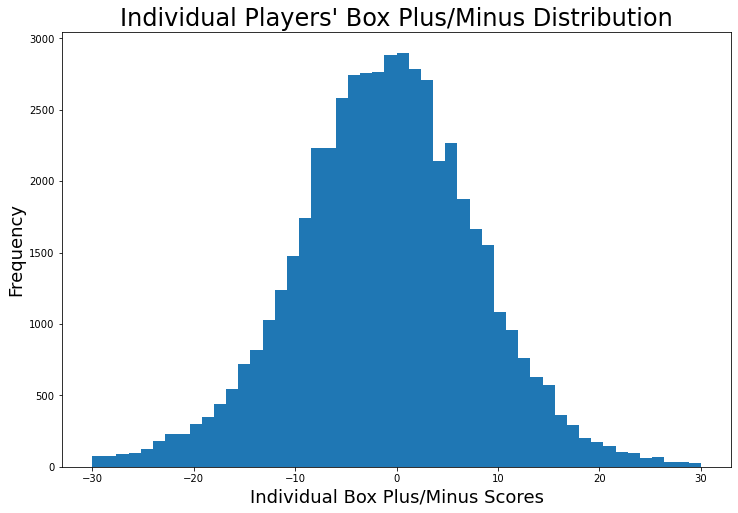

In [449]:
plt.figure(figsize = (12, 8))
plt.hist(df["Box Plus/Minus"],
        range = (-30,30),
        bins = 50)
plt.title("Individual Players' Box Plus/Minus Distribution", fontsize = 24)
plt.xlabel("Individual Box Plus/Minus Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18);

__Interpretation:__

In [450]:
 def bpm_result(dates, column):
    games_list = []
    
    for date in dates:
    
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)

        teams_played = []
        for i in range(0, len(indecies) -1):
            num = 0
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))

        for opponents in teams_played:
            team1, team2 = opponents
            
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
    
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
                        
            game = df.loc[(df["Date"] == date) & (df["Team"] == home_team) | 
                          (df["Date"] == date) & (df["Team"] == away_team), :]

            # Get the result of win or loss for the home team
            home_team_result = list(game.loc[game["Team"] == home_team, :]["Result"])[0]

            # Get the total team points in the game for team 1
            home_team_points = list(game.loc[(game["Team"] == home_team) &
                                             (game["Player"] == "Team Totals"), "Points"])[0]

            # Get the total team points in the game for team2
            away_team_points = list(game.loc[(game["Team"] == away_team) &
                                             (game["Player"] == "Team Totals"), "Points"])[0]

            # Collect the average BPM for team 1 in that game
            home_team_avg_bpm = round(game.loc[(game["Team"] == home_team) & 
                                               (game["Player"] != "Team Totals"), :][column].mean(), 4)
            
            # Collect the average BPM for team 2 in that game
            away_team_avg_bpm = round(game.loc[(game["Team"] == away_team) & 
                                               (game["Player"] != "Team Totals"), :][column].mean(), 4)

            # Collect the sum BPM for team 1 in that game
            home_team_sum_bpm = round(game.loc[(game["Team"] == home_team) & 
                                               (game["Player"] != "Team Totals"), :][column].sum(), 4)
        
            # Collect the sum BPM for team 2 in that game
            away_team_sum_bpm = round(game.loc[(game["Team"] == away_team) & 
                                               (game["Player"] != "Team Totals"), :][column].sum(), 4)

            season = list(game["Season"])[0]

            avg_bpm_difference = home_team_avg_bpm - away_team_avg_bpm
            sum_bpm_difference = home_team_sum_bpm - away_team_sum_bpm
            point_differential = home_team_points  - away_team_points
            
            if column == "Box Plus/Minus":
                col_header = "BPM"
            elif column == "Adjusted Box Plus/Minus":
                col_header = "Adjusted BPM"

            cols = ["Season", "Date", "Home Team", "Home Team Average " + col_header, "Home Team Summed " + col_header,
                    "Home Team Total Points", "Away Team", "Away Team Average " + col_header, 
                    "Away Team Summed " + col_header, "Away Team Total Points",
                    "Home Team Average " + col_header + " Difference", 
                    "Home Team Summed " + col_header + " Difference", 
                    "Home Team Point Differential", "Home Team Result"]

            game_info = dict(zip(cols,[season, date, home_team , home_team_avg_bpm, home_team_sum_bpm, 
                                       home_team_points,  away_team, away_team_avg_bpm, 
                                       away_team_sum_bpm, away_team_points, avg_bpm_difference, 
                                       sum_bpm_difference, point_differential, home_team_result]))
                        
            games_list.append(game_info)
    
    games_df = pd.DataFrame(games_list)                    
                        
    return games_df

In [451]:
bpm_df = bpm_result(sorted(df["Date"].unique()), "Box Plus/Minus")
bpm_df.head()

,Season,Date,Home Team,Home Team Average BPM,Home Team Summed BPM,Home Team Total Points,Away Team,Away Team Average BPM,Away Team Summed BPM,Away Team Total Points,Home Team Average BPM Difference,Home Team Summed BPM Difference,Home Team Point Differential,Home Team Result
0,2018,2017-10-17,Cleveland Cavaliers,-1.240,-12.4,102,Boston Celtics,-2.720,-27.2,99,1.48,14.8,3,W
1,2018,2017-10-17,Golden State Warriors,1.825,21.9,121,Houston Rockets,2.125,17.0,122,-0.30,4.9,-1,L
2,2018,2017-10-18,Boston Celtics,-0.440,-4.4,100,Milwaukee Bucks,0.330,3.3,108,-0.77,-7.7,-8,L
3,2018,2017-10-18,Washington Wizards,-1.290,-12.9,120,Philadelphia 76ers,-1.510,-15.1,115,0.22,2.2,5,W
4,2018,2017-10-18,Indiana Pacers,-0.570,-5.7,140,Brooklyn Nets,-2.650,-26.5,131,2.08,20.8,9,W


In [452]:
print (f'There are {bpm_df.shape[0]} games in this dataframe.')

There are 2460 games in this dataframe.


In [453]:
def bpm_checker(dataframe, cols):
    final_df = pd.DataFrame()
    metrics_df = pd.DataFrame()
    
    for col in cols:
        
        better_bpm_with_win = dataframe.loc[(dataframe["Home Team Result"] == "W") &
                                         (dataframe[col] > 0), "Home Team Result"].count()

        better_bpm_with_loss = dataframe.loc[(dataframe["Home Team Result"] == "L") &
                                         (dataframe[col] > 0), "Home Team Result"].count()

        worse_bpm_with_win = dataframe.loc[(dataframe["Home Team Result"] == "W") &
                                         (dataframe[col] < 0), "Home Team Result"].count()

        worse_bpm_with_loss = dataframe.loc[(dataframe["Home Team Result"] == "L") &
                                         (dataframe[col] < 0), "Home Team Result"].count()

        bpm_accuracy = np.array([better_bpm_with_win, better_bpm_with_loss, worse_bpm_with_win, worse_bpm_with_loss])

        bpm_accuracy = bpm_accuracy.reshape(2, 2)
        
        aggregate_type = col.split(" ")[2]

        bpm_accuracy_df = pd.DataFrame(bpm_accuracy,
                                          index = [aggregate_type + " Better BPM", aggregate_type + " Worse BPM"],
                                          columns = ["Wins", "Losses"])

        final_df = final_df.append(bpm_accuracy_df)
  
        metrics_list = []
        metrics = ["Accuracy", "Sensitivity", "Specificity"]
        cm_accuracy = round(100 * (better_bpm_with_win + worse_bpm_with_loss)/dataframe.shape[0], 2)
        cm_sensitivity = round(100 * better_bpm_with_win/(better_bpm_with_win + worse_bpm_with_win), 2)
        cm_specificity = round(100 * worse_bpm_with_loss/(better_bpm_with_loss + worse_bpm_with_loss), 2)
        
        metrics_list.append(dict(zip(metrics, [cm_accuracy, cm_sensitivity, cm_specificity])))
        cm_metrics = pd.DataFrame(metrics_list,
                                  index = [aggregate_type + " Score"])
        
        metrics_df = metrics_df.append(cm_metrics)

    
    return final_df, metrics_df

In [454]:
team_bpm, bpm_metrics = bpm_checker(bpm_df, ["Home Team Average BPM Difference", "Home Team Summed BPM Difference"])
team_bpm

,Wins,Losses
Average Better BPM,1102,242
Average Worse BPM,339,776
Summed Better BPM,1085,243
Summed Worse BPM,354,775


In [455]:
bpm_metrics

,Accuracy,Sensitivity,Specificity
Average Score,76.34,76.47,76.23
Summed Score,75.61,75.40,76.13


From these 2 dataframes, we can see how using the average score for entire team could make for a better predictor when it comes to using the team average. As such, we'll impute that for all the null values for the team totals.

In [546]:
for date in list(df["Date"].unique()):

    teams = list(df.loc[(df["Date"] == date), "Team"].unique())
    for team in teams:
        df.loc[(df["Team"] == team) &
               (df["Date"] == date) &
               (df["Player"] == "Team Totals"), "Box Plus/Minus"] = round(df.loc[(df["Team"] == team) &
                                                                                 (df["Date"] == date) &
                                                                                 (df["Player"] != "Team Totals"), 
                                                                                 "Box Plus/Minus"].mean(), 2)

df.loc[df["Player"] == "Team Totals", :].head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
12,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Team Totals,240.0,39,83,13,29,26,28,13,36,49,26,10,4,17,19,117,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,0.66,NaN
25,2018,Regular Season,2017-10-19,Chicago Bulls,CHI,Away,0.0,L,Team Totals,240.0,37,89,10,32,16,18,10,29,39,22,7,2,19,23,100,0.516,0.472,0.360,0.202,21.7,69.0,44.3,59.5,7.0,3.7,16.4,100.0,100.1,117.2,-1.31,NaN
39,2018,Regular Season,2017-10-21,Toronto Raptors,TOR,Home,0.0,W,Team Totals,240.0,42,89,13,44,31,37,8,43,51,23,5,10,13,29,128,0.608,0.545,0.494,0.416,19.5,84.3,55.4,54.8,4.7,17.2,11.0,100.0,119.1,87.4,3.24,NaN
52,2018,Regular Season,2017-10-21,Philadelphia 76ers,PHI,Away,0.0,L,Team Totals,240.0,32,82,8,24,22,36,8,33,41,18,5,4,20,26,94,0.480,0.439,0.293,0.439,15.7,80.5,44.6,56.3,4.7,8.9,17.0,100.0,87.4,119.1,-4.36,NaN
63,2018,Regular Season,2017-10-23,Toronto Raptors,TOR,Away,0.0,L,Team Totals,240.0,34,80,10,37,19,24,5,29,34,17,11,4,14,30,97,0.536,0.488,0.463,0.300,11.9,61.7,38.2,50.0,11.2,5.7,13.4,100.0,98.8,102.8,1.03,NaN


In [581]:
df.loc[df["Player"] == "Team Totals", "Box Plus/Minus"].describe()

count    4920.000000
mean       -1.235982
std         3.394712
min       -91.850000
25%        -2.690000
50%        -1.180000
75%         0.280000
max        42.420000
Name: Box Plus/Minus, dtype: float64

In [595]:
df.loc[(df["Player"] == "Team Totals") &
       (df["Box Plus/Minus"] < -20) |
       (df["Player"] == "Team Totals") &
       (df["Box Plus/Minus"] > 20), :]

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus
4959,2018,Regular Season,2018-03-01,Cleveland Cavaliers,CLE,Home,0.0,L,Team Totals,240.0,36,87,9,32,16,23,10,35,45,23,4,6,9,21,97,0.499,0.466,0.368,0.264,20.0,71.4,45.5,63.9,4.2,10.0,8.5,100.0,102.8,114.4,-21.17
19080,2018,Regular Season,2017-12-23,Dallas Mavericks,DAL,Away,0.0,L,Team Totals,240.0,43,85,9,33,12,15,7,23,30,31,8,3,10,17,107,0.584,0.559,0.388,0.176,17.9,79.3,44.1,72.1,8.7,5.9,9.8,100.0,116.0,121.5,-91.85
28248,2018,Regular Season,2018-02-13,Dallas Mavericks,DAL,Home,0.0,L,Team Totals,240.0,38,83,15,40,18,23,4,33,37,29,4,4,9,15,109,0.585,0.548,0.482,0.277,10.8,86.8,49.3,76.3,4.2,6.9,8.8,100.0,114.0,119.3,-65.44
31608,2019,Regular Season,2019-01-27,Dallas Mavericks,DAL,Home,0.0,L,Team Totals,240.0,43,88,11,36,23,34,7,36,43,25,5,2,11,29,120,0.583,0.551,0.409,0.386,16.3,81.8,49.4,58.1,5.0,4.1,9.7,100.0,119.4,122.4,42.42
38122,2019,Regular Season,2019-01-25,Brooklyn Nets,BRK,Home,0.0,W,Team Totals,240.0,34,84,9,33,32,47,18,42,60,19,5,2,19,21,109,0.521,0.458,0.393,0.560,40.0,87.5,64.5,55.9,5.0,3.6,15.4,100.0,109.5,99.4,27.95
40447,2019,Regular Season,2018-12-19,Minnesota Timberwolves,MIN,Home,1.0,L,Team Totals,265.0,45,103,9,33,24,29,11,38,49,22,8,4,7,27,123,0.531,0.481,0.320,0.282,23.4,82.6,52.7,48.9,7.4,8.7,5.7,100.0,113.7,119.3,-47.45
51191,2019,Regular Season,2019-03-07,Portland Trail Blazers,POR,Home,1.0,L,Team Totals,265.0,37,94,9,41,38,47,14,37,51,14,7,8,14,27,121,0.528,0.441,0.436,0.500,25.0,69.8,46.8,37.8,6.2,10.3,10.9,100.0,107.1,114.2,-81.60
53869,2019,Regular Season,2019-03-08,Oklahoma City Thunder,OKC,Away,0.0,L,Team Totals,240.0,41,102,11,44,17,26,14,38,52,20,3,7,11,34,110,0.485,0.456,0.431,0.255,24.6,79.2,49.5,48.8,2.8,11.5,8.8,100.0,104.1,111.7,-21.37


By comparing this dataset of team BPM outliers to the one above of individual BPM outliers, we can see how individual players can have huge pull on the teams average, despite having played less than 20 seconds of the total game.  


|Team|Date|Player|Minutes Played| Individual BPM|Index|Team BPM|
|-|-|-|-|-|-|-|
|Cleveland Cavaliers |  March 1, 2018| London Perrantes |12 seconds| -204 |4958|-21.17|
|Dallas Mavericks | December 23, 2017| Kyle Collinsworth| 1 second | -1000 |19079|-91.85|
| Dallas Mavericks | February 13, 2018| Jalen Jones| 3 seconds | -746.2 |28247|-65.44|
|Dallas Mavericks | January 27, 2019|Ryan Broekhoff| 16 seconds|517.4|31607|42.42|
|Brooklyn Nets| January 25, 2019|Mitch Creek | 2 seconds|317.9|38121|27.95|
|Minnesota TimberWolves | December 19, 2018| Anthony Tolliver| 5 seconds | -473 | 40446|-47.45|
|Portland TrailBlazers | March 7, 2019| Skal Labissière |2 seconds | -890.9 | 51190|-81.6|
| Oklahoma City Thunder | March 8, 2019| Donte Grantham| 9 seconds |-223.3 | 53868|-21.37|

this indicates that when calculating BPM for an individual game, it does not appear as if Minutes Played are accounted for, since BPM is a predictor of above league average points. The issue with this, is that all the players who played for very short periods of time become such potent outliers, as there is not enough data to truly predict their contributions. As such, let's create an _Adjusted_ version of BPM, to see if can help with our team totals. 

In [624]:
def adjusted_bpm_creator(overtime, bpm, mp):
    game_minutes = (overtime *5) + 48

    return round((bpm * mp)/ game_minutes, 2)

In [625]:
df["Adjusted Box Plus/Minus"] = adjusted_bpm_creator(df["Overtime"], df["Box Plus/Minus"], df["Minutes Played"])
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0,0,7,8,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3,-3.54
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,1,3,3,3,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3,1.50
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0,1,5,6,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3,2.73
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,3,6,2,2,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0,0.00
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,2,4,0,0,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0,-1.01


In [626]:
df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"].describe()

count    52193.000000
mean        -0.000216
std          4.012270
min        -14.580000
25%         -2.540000
50%         -0.320000
75%          2.190000
max         28.420000
Name: Adjusted Box Plus/Minus, dtype: float64

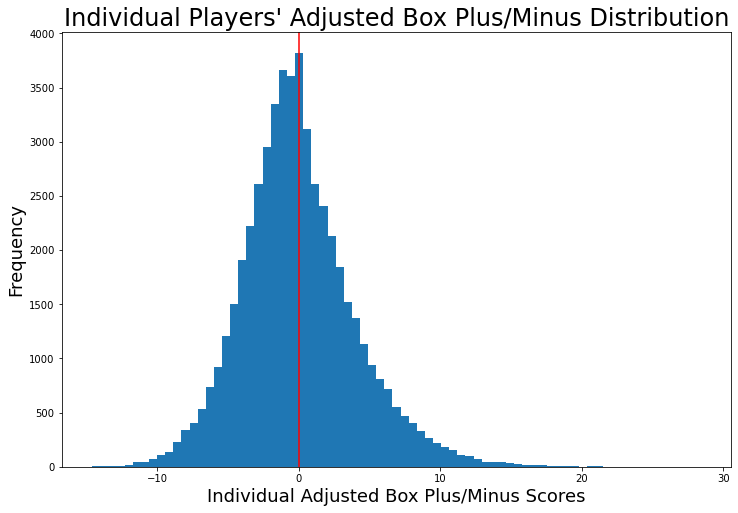

In [627]:
plt.figure(figsize = (12, 8))
plt.hist(df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"],
        bins = 75)
plt.axvline(df.loc[df["Player"] != "Team Totals", "Adjusted Box Plus/Minus"].mean(), color = "red")
plt.title("Individual Players' Adjusted Box Plus/Minus Distribution", fontsize = 24)
plt.xlabel("Individual Adjusted Box Plus/Minus Scores", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18);

In [628]:
adjusted_bpm_df = bpm_result(sorted(df["Date"].unique()), "Adjusted Box Plus/Minus")
adjusted_bpm_df.head()

,Season,Date,Home Team,Home Team Average Adjusted BPM,Home Team Summed Adjusted BPM,Home Team Total Points,Away Team,Away Team Average Adjusted BPM,Away Team Summed Adjusted BPM,Away Team Total Points,Home Team Average Adjusted BPM Difference,Home Team Summed Adjusted BPM Difference,Home Team Point Differential,Home Team Result
0,2018,2017-10-17,Cleveland Cavaliers,0.455,4.55,102,Boston Celtics,0.1020,1.02,99,0.3530,3.53,3,W
1,2018,2017-10-17,Golden State Warriors,0.850,10.20,121,Houston Rockets,1.4175,11.34,122,-0.5675,-1.14,-1,L
2,2018,2017-10-18,Boston Celtics,-0.353,-3.53,100,Milwaukee Bucks,0.6070,6.07,108,-0.9600,-9.60,-8,L
3,2018,2017-10-18,Washington Wizards,0.485,4.85,120,Philadelphia 76ers,-0.0930,-0.93,115,0.5780,5.78,5,W
4,2018,2017-10-18,Indiana Pacers,0.207,2.07,140,Brooklyn Nets,-0.7540,-7.54,131,0.9610,9.61,9,W


In [629]:
team_abpm, abpm_metrics = bpm_checker(adjusted_bpm_df, ["Home Team Average Adjusted BPM Difference",
                              "Home Team Summed Adjusted BPM Difference"])
team_abpm

,Wins,Losses
Average Better BPM,1439,1
Average Worse BPM,2,1018
Summed Better BPM,1441,0
Summed Worse BPM,0,1019


In [630]:
abpm_metrics

,Accuracy,Sensitivity,Specificity
Average Score,99.88,99.86,99.9
Summed Score,100.00,100.00,100.0


In [631]:
def my_histogram(column, bins, range = None):
    plt.figure(figsize = (10, 8))

    plt.hist(df.loc[df["Player"] == "Team Totals", column], bins = bins, range = range)
    plt.axvline(df.loc[df["Player"] == "Team Totals", column].mean(), color = "red")
    plt.title("The Distribution of Team " + column, fontsize = 24)
    plt.xlabel("Number of " + column, fontsize = 18)
    plt.ylabel("Frequency", fontsize = 18);

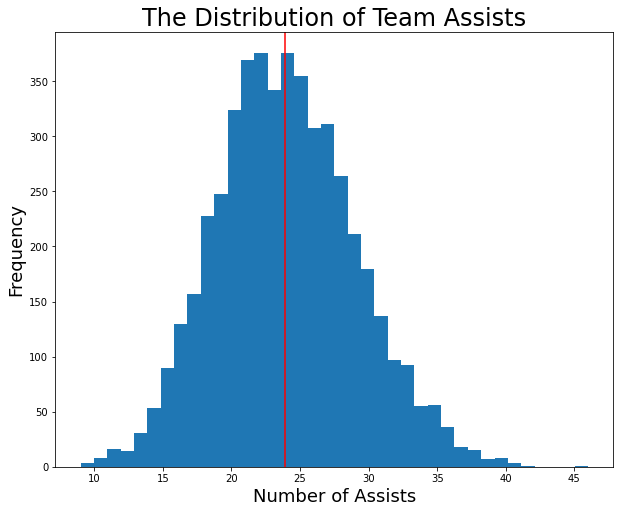

In [632]:
my_histogram("Assists", 38)

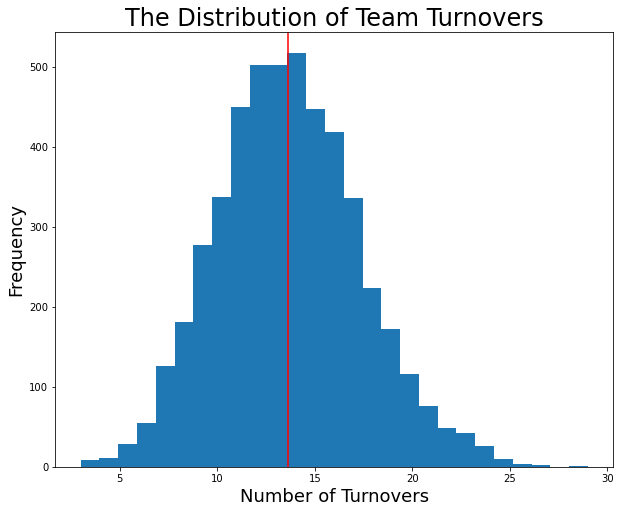

In [633]:
my_histogram("Turnovers", 27)

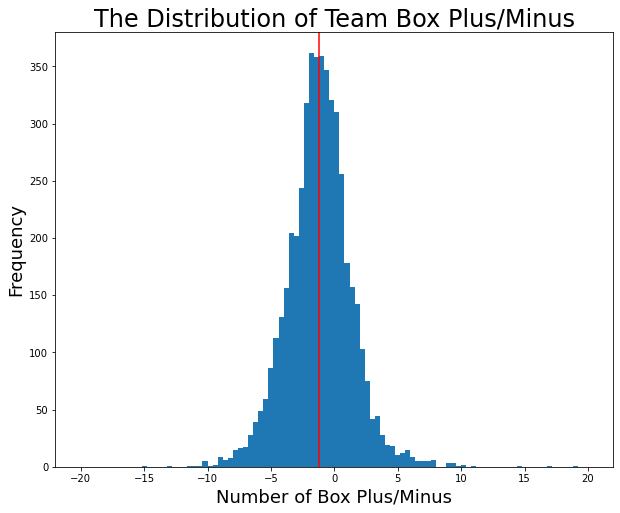

In [634]:
my_histogram("Box Plus/Minus", 100, range = (-20,20))

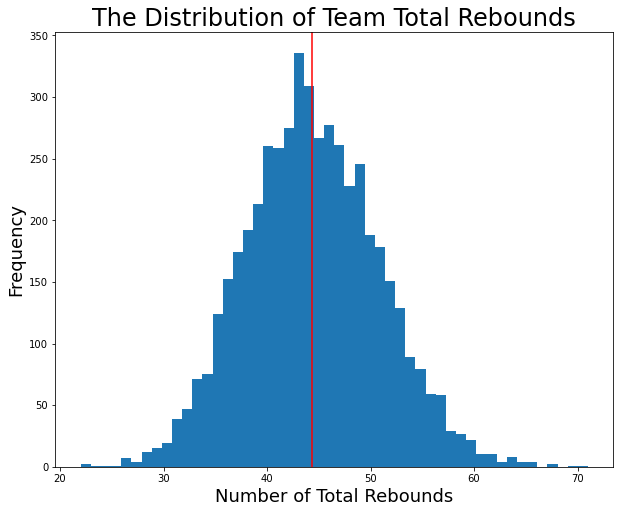

In [635]:
my_histogram("Total Rebounds", 50)

In [636]:
df.head()

,Season,Time Period,Date,Team,Team Abbreviation,Location,Overtime,Result,Player,Minutes Played,Field Goals,Field Goal Attempts,3-Point Field Goals,3-Point Attempts,Free Throws,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,True Shooting Percentage,Effective Field Goal Percentage,3 Point Attempt Rate,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Usage Percentage,Offensive Rating,Defensive Rating,Box Plus/Minus,Adjusted Box Plus/Minus
0,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,DeMar DeRozan,32.05,2,9,0,0,7,8,1,5,6,5,2,1,5,1,11,0.439,0.222,0.000,0.889,3.6,16.3,10.2,20.8,3.0,2.6,28.5,23.4,86.0,97.0,-5.3,-3.54
1,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Kyle Lowry,31.33,4,7,1,3,3,3,0,4,4,9,1,0,4,1,12,0.721,0.643,0.429,0.429,0.0,13.3,7.0,41.9,1.5,0.0,32.5,16.8,121.0,103.0,2.3,1.50
2,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Jonas Valančiūnas,30.50,9,17,0,1,5,6,8,7,15,2,2,0,1,4,23,0.586,0.529,0.059,0.353,30.0,23.9,26.8,12.7,3.2,0.0,4.8,28.9,136.0,96.0,4.3,2.73
3,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Norman Powell,24.58,5,11,3,6,2,2,0,4,4,1,1,0,2,2,15,0.631,0.591,0.545,0.182,0.0,17.0,8.9,6.7,2.0,0.0,14.4,24.1,111.0,101.0,0.0,0.00
4,2018,Regular Season,2017-10-19,Toronto Raptors,TOR,Home,0.0,W,Serge Ibaka,24.23,3,8,2,4,0,0,1,3,4,0,0,2,0,2,8,0.500,0.500,0.500,0.000,4.7,12.9,9.0,0.0,0.0,7.0,0.0,14.1,113.0,101.0,-2.0,-1.01


In [637]:
df.isna().sum()

Season                                0
Time Period                           0
Date                                  0
Team                                  0
Team Abbreviation                     0
Location                              0
Overtime                              0
Result                                0
Player                                0
Minutes Played                        0
Field Goals                           0
Field Goal Attempts                   0
3-Point Field Goals                   0
3-Point Attempts                      0
Free Throws                           0
Free Throw Attempts                   0
Offensive Rebounds                    0
Defensive Rebounds                    0
Total Rebounds                        0
Assists                               0
Steals                                0
Blocks                                0
Turnovers                             0
Personal Fouls                        0
Points                                0


### Offensive Rating vs. Defensive Rating

In [256]:
df.loc[(df["Offensive Rating"] > df["Defensive Rating"]) &
       (df["Player"] == "Team Totals") &
       (df["Result"] == "L"), "Result"].count()

0

In [467]:
df.loc[(df["Offensive Rating"] > df["Defensive Rating"]) &
       (df["Player"] == "Team Totals") &
       (df["Result"] == "W"), "Result"].count()

2460

## Current Game Model Preparation

### Team Totals DataFrame

In [704]:
def rename_values(dataframe, dictionary):
    for k,v in dictionary.items():
        dataframe[k] = dataframe[k].map(v)

In [705]:
result = {
    "W" : 1,
    "L" : 0
}

location = {
    "Home" : 1,
    "Away" : 0
}

columns_and_dicts = {
    "Result"   : result,
    "Location" : location
}

In [719]:
 def game_df(dates, primary_team):
    # Create an empty dataframe to append other dataframes to
    seasons = pd.DataFrame()
    # iterate through all the unique dates in our dataframe
    for date in dates:
        # collect all the indecies of the team totals for all teams that played on that day
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)
        
        # Create Tuples of the 2 teams that played each other on that day and add them to a list.
        teams_played = []
        
        # iterate through all the indecies except the last one
        for i in range(0, len(indecies) -1):
            # Our dataframe goes team by team in order for that team. This means games played on the same day will 
            # typically be separated by thousands of rows. As such, the indecies collected will not be in close
            # proximity to one another, UNLESS those 2 teams were playing each other that day. If they are close
            # together, we add the team names to the list in a Tuple.
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))
        
        # iterate through the tuples saved in our list
        for opponents in teams_played:
            team1, team2 = opponents # assign each team a variable.
            
            # check whether team1 was playing at home or away that game
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
            
            # reassign our variables to home and away teams
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
            
            # This dataframe needs to be collected twice - once with the home team listed first, and once with the
            # away team listed first. This is to avoid the model giving preference to the home team. Now we will assign
            # our variables as the main team or secondary team - which is dependent on whether we want the Home team
            # first or the Away team first.
            if primary_team == "Home":
                main_team = home_team
                secondary_team = away_team
            else:
                main_team = away_team
                secondary_team = home_team
                
            stripped_df = df.drop(columns = ["Time Period", "Team Abbreviation", "Field Goals", "3-Point Field Goals",
                                            "Free Throws", "Total Rebounds", "Points", "Usage Percentage", 
                                            "Offensive Rating", "Defensive Rating", "3 Point Attempt Rate"])
                
            main_df = stripped_df.loc[(stripped_df["Date"] == date) &
                                      (stripped_df["Team"] == main_team) &
                                      (stripped_df["Player"] == "Team Totals"), :].copy()
            
            main_df = main_df.drop(columns = "Player")
            
            rename_values(main_df, columns_and_dicts)
            
            main_df.reset_index(inplace = True, drop = True)

            secondary_df = stripped_df.loc[(stripped_df["Date"] == date) &
                                           (stripped_df["Team"] == secondary_team) &
                                           (stripped_df["Player"] == "Team Totals"), :].copy()
            
            rename_values(secondary_df, columns_and_dicts)
            
            secondary_df = secondary_df.drop(columns = ["Season", "Date", "Result", "Player", "Overtime",
                                                        "Minutes Played"])
            

            
            prefix = "Secondary Team "
            
            for column in list(secondary_df.columns[1:]):
                secondary_df.rename(columns = {
                    column : prefix + column
                }, inplace = True)
                
            secondary_df.rename(columns = {
                "Team" : prefix
            }, inplace = True)
                
            secondary_df.reset_index(inplace = True, drop = True)
            
            game = pd.concat([main_df, secondary_df], axis = 1)
                        
            seasons = seasons.append(game)  
            
        seasons.reset_index(inplace = True, drop = True)
                        
    return seasons

In [720]:
game_df(["2017-10-17", "2017-10-18"], "Home")

,Season,Date,Team,Location,Overtime,Result,Minutes Played,Field Goal Attempts,3-Point Attempts,Free Throw Attempts,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,True Shooting Percentage,Effective Field Goal Percentage,Free Throw Attempt Rate,Offensive Rebound Percentage,Defensive Rebound Percentage,Total Rebound Percentage,Assist Percentage,Steal Percentage,Block Percentage,Turnover Percentage,Box Plus/Minus,Adjusted Box Plus/Minus,Secondary Team,Secondary Team Location,Secondary Team Field Goal Attempts,Secondary Team 3-Point Attempts,Secondary Team Free Throw Attempts,Secondary Team Offensive Rebounds,Secondary Team Defensive Rebounds,Secondary Team Assists,Secondary Team Steals,Secondary Team Blocks,Secondary Team Turnovers,Secondary Team Personal Fouls,Secondary Team True Shooting Percentage,Secondary Team Effective Field Goal Percentage,Secondary Team Free Throw Attempt Rate,Secondary Team Offensive Rebound Percentage,Secondary Team Defensive Rebound Percentage,Secondary Team Total Rebound Percentage,Secondary Team Assist Percentage,Secondary Team Steal Percentage,Secondary Team Block Percentage,Secondary Team Turnover Percentage,Secondary Team Box Plus/Minus,Secondary Team Adjusted Box Plus/Minus
0,2018,2017-10-17,Cleveland Cavaliers,1,0.0,1,240.0,83,22,25,9,41,19,3,4,17,25,0.543,0.488,0.301,19.6,82.0,52.1,50.0,3.0,7.1,15.3,-1.24,-6.20,Boston Celtics,0,88,32,25,9,37,24,11,4,10,24,0.500,0.455,0.284,18.0,80.4,47.9,66.7,11.1,6.6,9.2,-2.72,-13.60
1,2018,2017-10-17,Golden State Warriors,1,0.0,0,240.0,80,30,21,6,35,34,5,9,17,25,0.678,0.638,0.263,15.4,77.8,48.8,79.1,4.9,16.1,16.0,1.82,9.10,Houston Rockets,0,97,41,19,10,33,28,9,5,12,16,0.579,0.562,0.196,22.2,84.6,51.2,59.6,8.8,10.0,10.2,2.12,10.60
2,2018,2017-10-18,Boston Celtics,1,0.0,0,240.0,91,28,21,11,32,23,12,2,12,27,0.499,0.489,0.231,22.0,84.2,48.9,59.0,12.3,3.6,10.7,-0.44,-2.20,Milwaukee Bucks,0,76,21,30,6,39,19,6,4,15,22,0.605,0.546,0.395,15.8,78.0,51.1,50.0,6.1,6.3,14.4,0.33,1.65
3,2018,2017-10-18,Washington Wizards,1,0.0,1,240.0,97,22,38,16,36,21,8,10,9,20,0.528,0.464,0.392,30.2,76.6,52.0,50.0,7.7,17.2,7.3,-1.29,-6.45,Philadelphia 76ers,0,93,35,19,11,37,25,6,6,17,28,0.567,0.543,0.204,23.4,69.8,48.0,58.1,5.8,8.0,14.4,-1.51,-7.55
4,2018,2017-10-18,Indiana Pacers,1,0.0,1,240.0,102,34,32,14,33,29,12,9,14,25,0.603,0.564,0.314,30.4,75.0,52.2,54.7,10.6,14.1,10.8,-0.57,-2.85,Brooklyn Nets,0,94,30,32,11,32,22,7,2,20,25,0.606,0.543,0.340,25.0,69.6,47.8,48.9,6.2,2.9,15.6,-2.65,-13.25
5,2018,2017-10-18,Orlando Magic,1,0.0,1,240.0,90,21,29,11,39,22,8,9,14,18,0.564,0.522,0.322,25.0,78.0,53.2,51.2,7.6,12.7,12.0,-0.39,-1.95,Miami Heat,0,101,30,17,11,33,27,6,4,13,20,0.502,0.475,0.168,22.0,75.0,46.8,61.4,5.7,5.8,10.7,-3.41,-17.05
6,2018,2017-10-18,Detroit Pistons,1,0.0,1,240.0,96,26,12,9,38,24,14,3,8,21,0.504,0.474,0.125,17.0,92.7,50.0,58.5,14.2,7.0,7.3,1.02,5.10,Charlotte Hornets,0,73,30,29,3,44,16,4,3,17,15,0.525,0.459,0.397,7.3,83.0,50.0,55.2,4.1,4.3,16.5,-1.55,-7.75
7,2018,2017-10-18,Dallas Mavericks,1,0.0,0,240.0,86,45,21,9,32,27,5,4,15,19,0.583,0.541,0.244,20.0,69.6,45.1,71.1,5.1,5.3,13.6,-1.28,-6.40,Atlanta Hawks,0,94,18,15,14,36,20,11,6,13,18,0.582,0.559,0.160,30.4,80.0,54.9,41.7,11.2,14.6,11.4,0.95,4.75
8,2018,2017-10-18,Sacramento Kings,1,0.0,0,240.0,88,23,10,9,33,19,5,4,17,20,0.541,0.523,0.114,22.0,73.3,48.8,45.2,5.2,10.5,15.5,-2.46,-12.30,Houston Rockets,0,83,45,29,12,32,19,7,3,14,14,0.548,0.470,0.349,26.7,78.0,51.2,57.6,7.3,4.6,12.8,0.20,1.00
9,2018,2017-10-18,Phoenix Suns,1,0.0,0,240.0,89,27,18,10,23,10,9,8,16,22,0.392,0.354,0.202,19.2,60.5,36.7,35.7,9.1,12.1,14.2,-6.16,-30.80,Portland Trail Blazers,0,90,24,28,15,42,22,8,7,16,20,0.606,0.567,0.311,39.5,80.8,63.3,50.0,8.1,11.3,13.5,3.45,17.25


### Previous Game Model Preparation

In [658]:
# This function was pulled from Mahdi's Linear Time Series Lecture
def multi_lag_appender(dataframe, columns, lags, inplace = False):
    '''Appends the appropriate lag from the list of given lags to the give dataframe'''
    # copying dataframe unless inplace = True
    
    dataframe = dataframe if inplace else dataframe.copy()
    for lag in lags:
        for column in columns:
            dataframe[f"{column}_{lag}"] = dataframe[column].shift(lag)
    
    return None if inplace else dataframe

In [710]:
columns_and_dicts_lag = {
    "Result"     : result,
    "Result_1"   : result,
    "Location"   : location,
    "Location_1" : location
}

In [713]:
def lagged_df(dates, primary_team):
    full_league_lagged_games_df = pd.DataFrame()
    full_league_lagged_df = pd.DataFrame()
    
    for team in list(df["Team"].unique()):
        team_df = df.loc[(df["Team"] == team) &
                         (df["Player"] == "Team Totals"), :].copy()
        
        team_df.sort_values(by = "Date", inplace = True)
        team_df.reset_index(inplace = True, drop = True)
        
        lag_columns = list(df.drop(columns = ["Season", "Time Period", "Team", 
                                              "Team Abbreviation", "Player", ]).columns)
    
    
        team_df_with_lags = multi_lag_appender(team_df, lag_columns, [1])
        team_df_with_lags.drop(index = 0, inplace = True)
        
        full_league_lagged_df = full_league_lagged_df.append(team_df_with_lags)
    
    
    full_league_lagged_df.reset_index(inplace = True, drop = True)
    
    drop_columns = list(df.drop(columns = ["Season","Date", "Team", "Location", "Result"]).columns)
    full_league_lagged_df.drop(columns = drop_columns, inplace = True)
    
# iterate through all the unique dates in our dataframe
    for date in dates:
        # collect all the indecies of the team totals for all teams that played on that day
        indecies = list(df.loc[(df["Date"] == date) & 
                       (df["Player"] == "Team Totals"), :].index)
        
        # Create Tuples of the 2 teams that played each other on that day and add them to a list.
        teams_played = []
        
        # iterate through all the indecies except the last one
        for i in range(0, len(indecies) -1):
            # Our dataframe goes team by team in order for that team. This means games played on the same day will 
            # typically be separated by thousands of rows. As such, the indecies collected will not be in close
            # proximity to one another, UNLESS those 2 teams were playing each other that day. If they are close
            # together, we add the team names to the list in a Tuple.
            if indecies[i + 1] - indecies[i] < 20:
                teams_played.append((df.loc[indecies[i], "Team"], df.loc[indecies[i + 1], "Team"]))
        
        # iterate through the tuples saved in our list
        for opponents in teams_played:
            team1, team2 = opponents # assign each team a variable.
            
            # check whether team1 was playing at home or away that game
            location_status = list(df.loc[(df["Date"] == date) &
                                  (df["Team"] == team1), :]["Location"])[0]
            
            # reassign our variables to home and away teams
            if location_status == "Home":
                home_team = team1
            else:
                home_team = team2

            if home_team == team1:
                away_team = team2
            else:
                away_team = team1
            
            # This dataframe needs to be collected twice - once with the home team listed first, and once with the
            # away team listed first. This is to avoid the model giving preference to the home team. Now we will assign
            # our variables as the main team or secondary team - which is dependent on whether we want the Home team
            # first or the Away team first.
            if primary_team == "Home":
                main_team = home_team
                secondary_team = away_team
            else:
                main_team = away_team
                secondary_team = home_team
                
            main_df = full_league_lagged_df.loc[(full_league_lagged_df["Date"] == date) &
                                                (full_league_lagged_df["Team"] == main_team), :].copy()
            
            rename_values(main_df, columns_and_dicts_lag)
            
            main_df.reset_index(inplace = True, drop = True)
            
            secondary_df = full_league_lagged_df.loc[(full_league_lagged_df["Date"] == date) &
                                                     (full_league_lagged_df["Team"] == secondary_team), :].copy()
            
            rename_values(secondary_df, columns_and_dicts_lag)
            
            secondary_df = secondary_df.drop(columns = ["Season", "Date", "Result"])
            
            prefix = "Secondary Team "
            
            for column in list(secondary_df.columns[1:]):
                secondary_df.rename(columns = {
                    column : prefix + column
                }, inplace = True)
                
            secondary_df.rename(columns = {
                "Team" : prefix
            }, inplace = True)
                
            secondary_df.reset_index(inplace = True, drop = True)
            
            game = pd.concat([main_df, secondary_df], axis = 1)
            
            full_league_lagged_games_df = full_league_lagged_games_df.append(game)
    
    full_league_lagged_games_df.reset_index(inplace = True, drop = True)
    
    return full_league_lagged_games_df

In [714]:
lagged_df(["2017-10-21"], "Home")

,Season,Date,Team,Location,Result,Date_1,Location_1,Overtime_1,Result_1,Minutes Played_1,Field Goals_1,Field Goal Attempts_1,3-Point Field Goals_1,3-Point Attempts_1,Free Throws_1,Free Throw Attempts_1,Offensive Rebounds_1,Defensive Rebounds_1,Total Rebounds_1,Assists_1,Steals_1,Blocks_1,Turnovers_1,Personal Fouls_1,Points_1,True Shooting Percentage_1,Effective Field Goal Percentage_1,3 Point Attempt Rate_1,Free Throw Attempt Rate_1,Offensive Rebound Percentage_1,Defensive Rebound Percentage_1,Total Rebound Percentage_1,Assist Percentage_1,Steal Percentage_1,Block Percentage_1,Turnover Percentage_1,Usage Percentage_1,Offensive Rating_1,Defensive Rating_1,Box Plus/Minus_1,Adjusted Box Plus/Minus_1,Secondary Team,Secondary Team Location,Secondary Team Date_1,Secondary Team Location_1,Secondary Team Overtime_1,Secondary Team Result_1,Secondary Team Minutes Played_1,Secondary Team Field Goals_1,Secondary Team Field Goal Attempts_1,Secondary Team 3-Point Field Goals_1,Secondary Team 3-Point Attempts_1,Secondary Team Free Throws_1,Secondary Team Free Throw Attempts_1,Secondary Team Offensive Rebounds_1,Secondary Team Defensive Rebounds_1,Secondary Team Total Rebounds_1,Secondary Team Assists_1,Secondary Team Steals_1,Secondary Team Blocks_1,Secondary Team Turnovers_1,Secondary Team Personal Fouls_1,Secondary Team Points_1,Secondary Team True Shooting Percentage_1,Secondary Team Effective Field Goal Percentage_1,Secondary Team 3 Point Attempt Rate_1,Secondary Team Free Throw Attempt Rate_1,Secondary Team Offensive Rebound Percentage_1,Secondary Team Defensive Rebound Percentage_1,Secondary Team Total Rebound Percentage_1,Secondary Team Assist Percentage_1,Secondary Team Steal Percentage_1,Secondary Team Block Percentage_1,Secondary Team Turnover Percentage_1,Secondary Team Usage Percentage_1,Secondary Team Offensive Rating_1,Secondary Team Defensive Rating_1,Secondary Team Box Plus/Minus_1,Secondary Team Adjusted Box Plus/Minus_1
0,2018,2017-10-21,Toronto Raptors,1,1,2017-10-19,1,0.0,1,240.0,39.0,83.0,13.0,29.0,26.0,28.0,13.0,36.0,49.0,26.0,10.0,4.0,17.0,19.0,117.0,0.614,0.548,0.349,0.337,31.0,78.3,55.7,66.7,10.0,7.0,15.1,100.0,117.2,100.1,0.66,3.30,Philadelphia 76ers,0,2017-10-20,1,0.0,0,240.0,35.0,92.0,10.0,32.0,12.0,16.0,14.0,33.0,47.0,20.0,7.0,4.0,16.0,30.0,92.0,0.464,0.435,0.348,0.174,25.5,70.2,46.1,57.1,7.0,7.3,13.9,100.0,92.4,102.5,-1.60,-8.00
1,2018,2017-10-21,Cleveland Cavaliers,1,0,2017-10-20,0,0.0,1,240.0,44.0,81.0,11.0,26.0,17.0,17.0,9.0,35.0,44.0,25.0,8.0,3.0,17.0,11.0,116.0,0.656,0.611,0.321,0.210,29.0,81.4,59.5,56.8,8.6,6.4,16.1,100.0,125.2,104.7,9.33,46.65,Orlando Magic,0,2017-10-20,0,0.0,0,240.0,45.0,89.0,18.0,33.0,13.0,15.0,9.0,31.0,40.0,30.0,9.0,3.0,22.0,27.0,121.0,0.633,0.607,0.371,0.169,21.4,67.4,45.5,66.7,8.4,4.6,18.7,100.0,112.6,117.3,-3.07,-15.35
2,2018,2017-10-21,Miami Heat,1,1,2017-10-18,0,0.0,0,240.0,44.0,101.0,8.0,30.0,13.0,17.0,11.0,33.0,44.0,27.0,6.0,4.0,13.0,20.0,109.0,0.502,0.475,0.297,0.168,22.0,75.0,46.8,61.4,5.7,5.8,10.7,100.0,103.6,110.3,-3.41,-17.05,Indiana Pacers,0,2017-10-20,1,0.0,0,240.0,35.0,78.0,4.0,18.0,22.0,33.0,6.0,33.0,39.0,15.0,1.0,4.0,12.0,17.0,96.0,0.519,0.474,0.231,0.423,13.0,75.0,43.3,42.9,1.0,5.3,11.5,100.0,98.5,117.0,-1.09,-5.45
3,2018,2017-10-21,Milwaukee Bucks,1,1,2017-10-20,1,0.0,0,240.0,38.0,82.0,11.0,35.0,10.0,12.0,8.0,22.0,30.0,23.0,9.0,2.0,14.0,17.0,97.0,0.556,0.530,0.427,0.146,18.6,71.0,40.5,60.5,9.7,3.6,13.8,100.0,104.7,125.2,-7.82,-39.10,Portland Trail Blazers,0,2017-10-20,0,0.0,1,240.0,46.0,95.0,9.0,19.0,13.0,17.0,11.0,40.0,51.0,19.0,5.0,6.0,9.0,26.0,114.0,0.556,0.532,0.200,0.179,25.0,87.0,56.7,41.3,5.1,10.0,8.1,100.0,117.0,98.5,-1.80,-9.00
4,2018,2017-10-21,New York Knicks,1,0,2017-10-19,0,0.0,0,240.0,32.0,79.0,7.0,24.0,13.0,19.0,11.0,30.0,41.0,19.0,8.0,4.0,25.0,23.0,84.0,0.481,0.449,0.304,0.241,28.2,69.8,50.0,59.4,8.1,7.7,22.2,100.0,85.0,106.2,1.37,6.85,Detroit Pistons,0,2017-10-20,0,0.0,0,240.0,43.0,87.0,10.0,23.0,15.0,20.0,10.0,23.0,33.0,19.0,12.0,1.0,19.0,32.0,111.0